# Imports

In [29]:
import pandas as pd
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from gensim.models.keyedvectors import KeyedVectors
import gensim.downloader as api

# 1. Computing General Statistics

In [2]:
df = pd.read_csv('NikeProductDescriptions.csv')

In [8]:
# General overview
print(df.shape)
print(df.info())
print(df.describe(include='all'))

(400, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                400 non-null    object
 1   Subtitle             400 non-null    object
 2   Product Description  400 non-null    object
dtypes: object(3)
memory usage: 9.5+ KB
None
                  Title       Subtitle  \
count               400            400   
unique              254            228   
top     Nike Sportswear  Women's Shoes   
freq                 41             34   

                                      Product Description  
count                                                 400  
unique                                                400  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


# 2. Filtering data

In [9]:
keep_subtitles = [
    "Men's Shoes", "Men's T-Shirt", "Women's Shoes", 
    "Skate Shoes", "Older Kids' T-Shirt"
]
df_filtered = df[df['Subtitle'].isin(keep_subtitles) | df['Subtitle'].str.contains('Shorts', na=False)].copy()

# renaming everything containing shorts to shorts
df_filtered.loc[df_filtered['Subtitle'].str.contains('Shorts', na=False), 'Subtitle'] = 'Shorts'

In [10]:
print(df_filtered.shape)
print(df_filtered.info())
print(df_filtered.describe(include='all'))

(155, 3)
<class 'pandas.core.frame.DataFrame'>
Index: 155 entries, 0 to 395
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Title                155 non-null    object
 1   Subtitle             155 non-null    object
 2   Product Description  155 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
None
                  Title Subtitle  \
count               155      155   
unique              117        6   
top     Nike Sportswear   Shorts   
freq                 13       45   

                                      Product Description  
count                                                 155  
unique                                                155  
top     It doesn't get more legendary than this. Desig...  
freq                                                    1  


# 3. Cleaning data text

In [21]:
# nltk.download('punkt')
# nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(raw_text):
    words = nltk.word_tokenize(raw_text)
    words = [re.sub(r'[^a-zA-Z]', '', word) for word in words]  # remove special characters
    words = [stemmer.stem(word.lower()) for word in words if word.lower() not in stop_words and word.isalpha()]
    return words

In [46]:
df_filtered['clean_tokens'] = df_filtered['Product Description'].fillna('').apply(clean_text)

# joining back into string for the next BOW/TF-IDF
df_filtered['clean_text'] = df_filtered['clean_tokens'].apply(lambda tokens: ' '.join(tokens))

In [36]:
df_filtered = df_filtered.sort_values(by='Subtitle')
# sorting to have a better visualization for the correlation matrix

# 4. methods application

### Note

For the correlation matrix, we will use subtitles instead of description indices so we can better interpret the heat map

## BOW

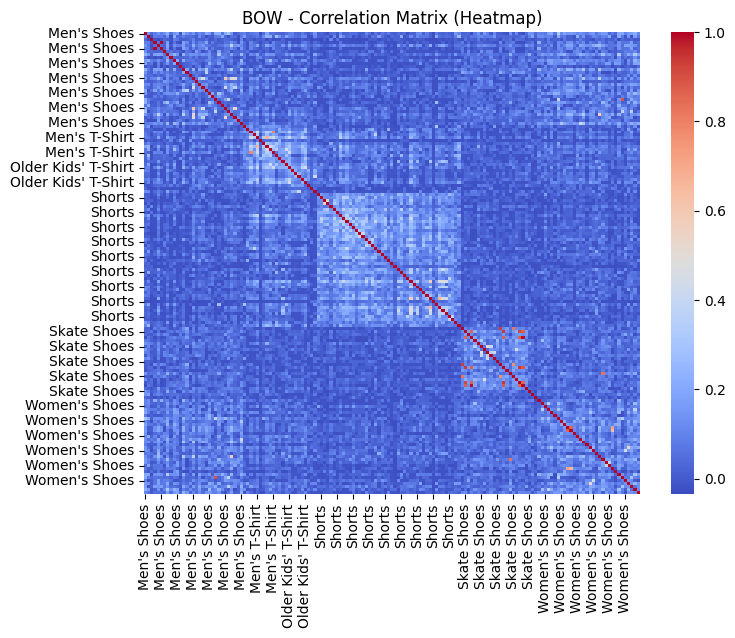

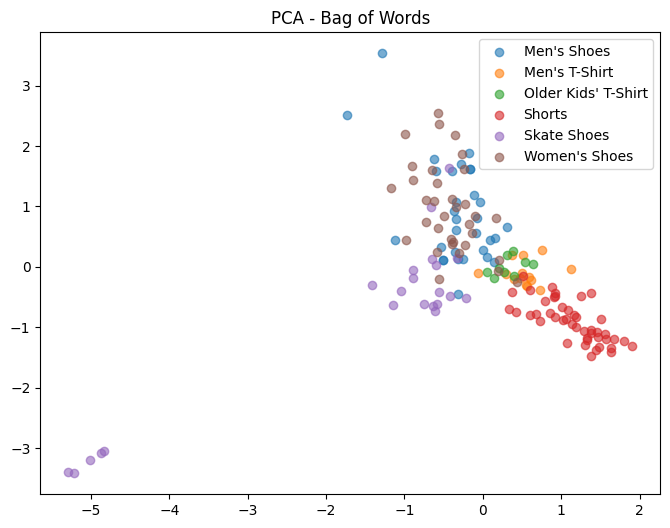

In [47]:
# --- BOW Matrix ---
vectorizer = CountVectorizer()
bow_matrix = vectorizer.fit_transform(df_filtered['clean_text']).toarray()

# --- Correlation Matrix ---
bow_corr = pd.DataFrame(bow_matrix).T.corr()
bow_corr.index = df_filtered['Subtitle'].values
bow_corr.columns = df_filtered['Subtitle'].values

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(bow_corr, cmap="coolwarm", annot=False)
plt.title("BOW - Correlation Matrix (Heatmap)")
plt.show()

# --- PCA Plot ---
pca_bow = PCA(n_components=2).fit_transform(bow_matrix)

plt.figure(figsize=(8,6))
for label in df_filtered['Subtitle'].unique():
    ix = df_filtered['Subtitle'] == label
    plt.scatter(pca_bow[ix, 0], pca_bow[ix, 1], label=label, alpha=0.6)
plt.legend()
plt.title("PCA - Bag of Words")
plt.show()


## TF-IDF

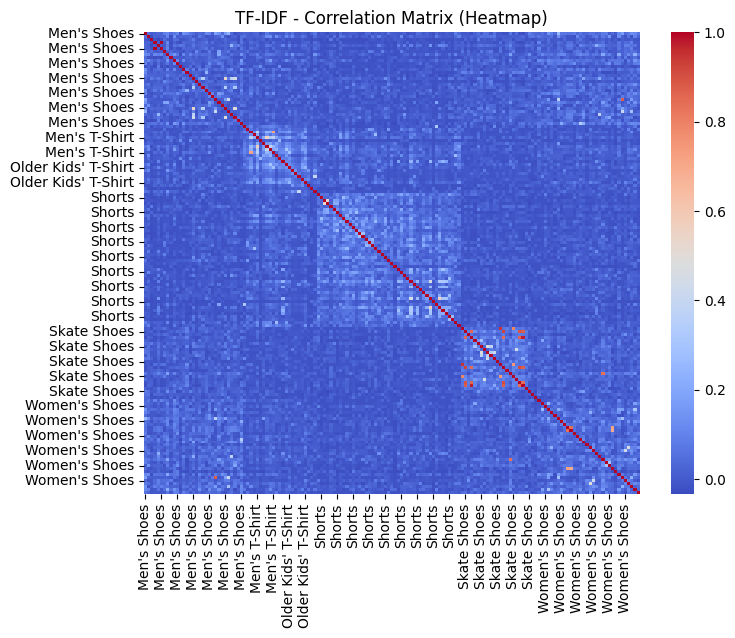

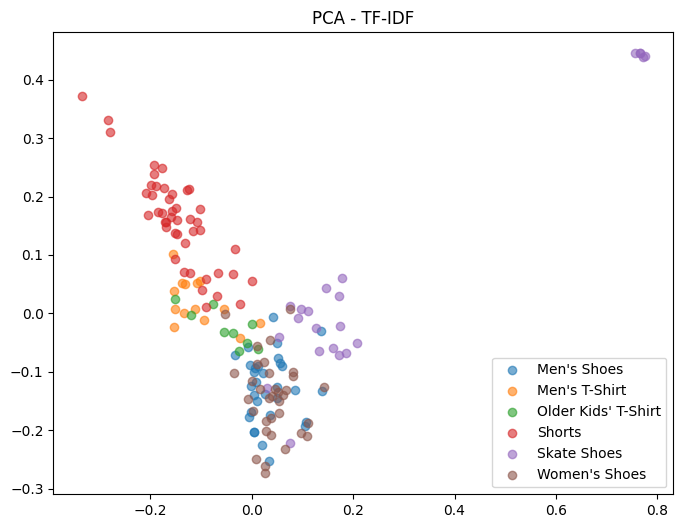

In [49]:
# --- TF-IDF Matrix ---
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df_filtered['clean_text']).toarray()

# --- Correlation Matrix ---
tfidf_corr = pd.DataFrame(tfidf_matrix).T.corr()
tfidf_corr.index = df_filtered['Subtitle'].values
tfidf_corr.columns = df_filtered['Subtitle'].values

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(tfidf_corr, cmap="coolwarm", annot=False)
plt.title("TF-IDF - Correlation Matrix (Heatmap)")
plt.show()

# --- PCA Plot ---
pca_tfidf = PCA(n_components=2).fit_transform(tfidf_matrix)

plt.figure(figsize=(8,6))
for label in df_filtered['Subtitle'].unique():
    ix = df_filtered['Subtitle'] == label
    plt.scatter(pca_tfidf[ix, 0], pca_tfidf[ix, 1], label=label, alpha=0.6)
plt.legend()
plt.title("PCA - TF-IDF")
plt.show()

## Word2Vec

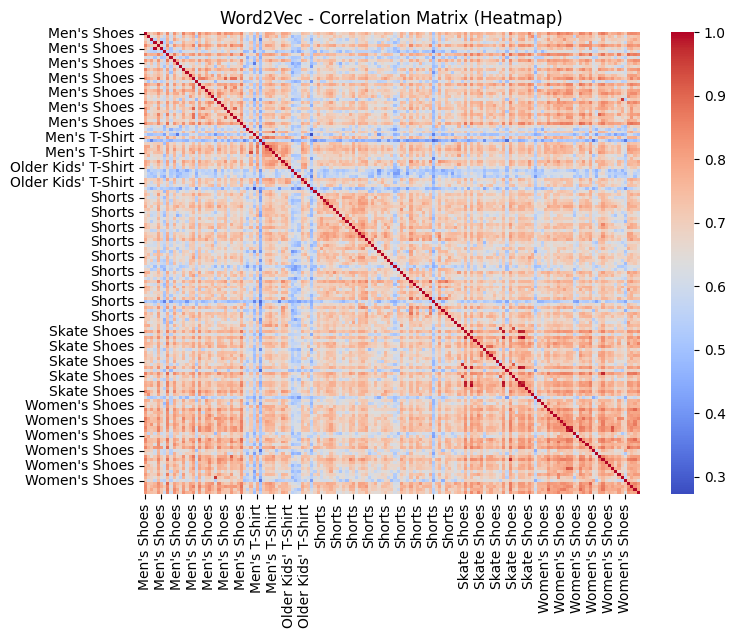

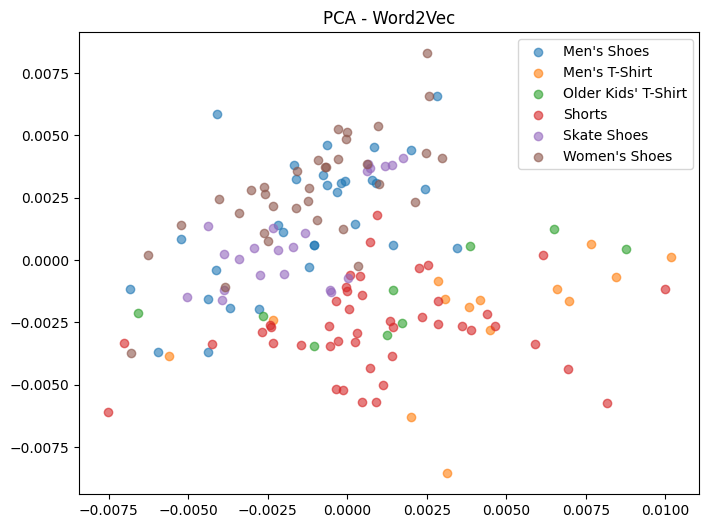

In [50]:
# --- Word2Vec ---
w2v_model = Word2Vec(sentences=df_filtered['clean_tokens'], vector_size=100, window=5, min_count=1, workers=4)

# --- Average Embeddings ---
def average_vector(tokens, model):
    valid = [model.wv[word] for word in tokens if word in model.wv]
    return np.mean(valid, axis=0) if valid else np.zeros(model.vector_size)

w2v_vectors = np.array([average_vector(tokens, w2v_model) for tokens in df_filtered['clean_tokens']])

# --- Correlation Matrix ---
w2v_corr = pd.DataFrame(w2v_vectors).T.corr()
w2v_corr.index = df_filtered['Subtitle'].values
w2v_corr.columns = df_filtered['Subtitle'].values

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(w2v_corr, cmap="coolwarm", annot=False)
plt.title("Word2Vec - Correlation Matrix (Heatmap)")
plt.show()

# --- PCA Plot ---
pca_w2v = PCA(n_components=2).fit_transform(w2v_vectors)

plt.figure(figsize=(8,6))
for label in df_filtered['Subtitle'].unique():
    ix = df_filtered['Subtitle'] == label
    plt.scatter(pca_w2v[ix, 0], pca_w2v[ix, 1], label=label, alpha=0.6)
plt.legend()
plt.title("PCA - Word2Vec")
plt.show()


## Glove

In [34]:
glove_model = api.load("glove-wiki-gigaword-100")

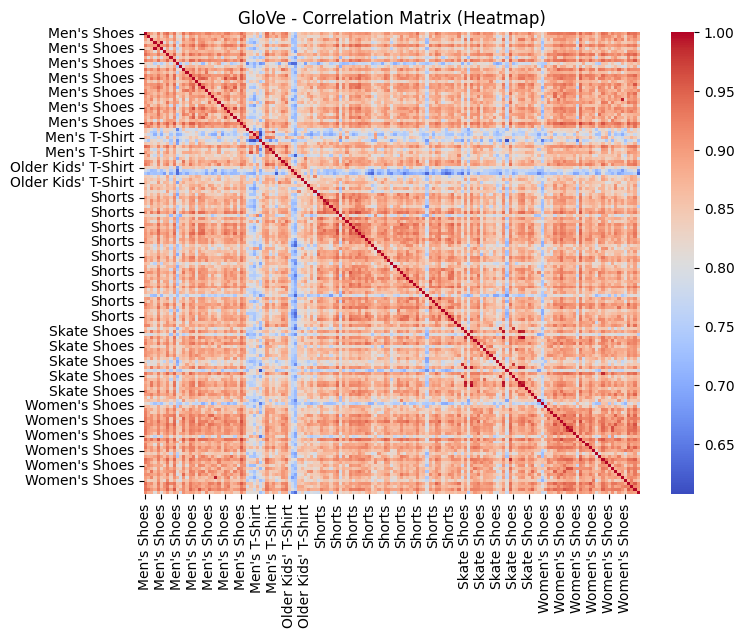

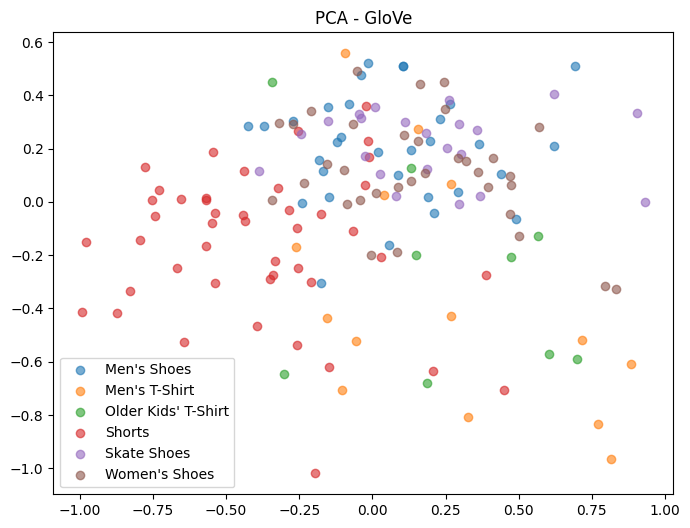

In [44]:
# --- Average Embeddings ---
def glove_avg_vector(tokens, model):
    valid = [model[word] for word in tokens if word in model]
    return np.mean(valid, axis=0) if valid else np.zeros(model.vector_size)

glove_vectors = np.array([glove_avg_vector(tokens, glove_model) for tokens in df_filtered['clean_tokens']])

# --- Correlation Matrix ---
glove_corr = pd.DataFrame(glove_vectors).T.corr()
glove_corr.index = df_filtered['Subtitle'].values
glove_corr.columns = df_filtered['Subtitle'].values

# --- Correlation Heatmap ---
plt.figure(figsize=(8,6))
sns.heatmap(glove_corr, cmap="coolwarm", annot=False)
plt.title("GloVe - Correlation Matrix (Heatmap)")
plt.show()

# --- PCA Plot ---
pca_glove = PCA(n_components=2).fit_transform(glove_vectors)

plt.figure(figsize=(8,6))
for label in df_filtered['Subtitle'].unique():
    ix = df_filtered['Subtitle'] == label
    plt.scatter(pca_glove[ix, 0], pca_glove[ix, 1], label=label, alpha=0.6)
plt.legend()
plt.title("PCA - GloVe")
plt.show()

## Comparision and Analysis

As expected, we can see that BOW and TF-IDF created better clusters, while the PCA components for Word2Vec and GloVe show spread data.

This is reflected on the correlation matrices too, where BOW and TF-IDF barely show any correlation between the different subtitles, in contrast, we can clearly see the correlation between most of them according to Word2Vec and GloVe. 

The reason is, BOW and TF-IDF are based on Term frequency, and thus create sharp clusters, while Word2Vec and GloVe's correlation is based on semantic meaning of the words

In conclusion, choosing the best method depends on the goal we want to focus on. The first two methods can be good for product grouping since they create better clusters, while the 2 others are best for semantic purposes, like search, and generalization.